# Creating the Ceramics (Huacos) Data Set from Google Images

The next few lines follow the instructions from https://github.com/fastai/course-v3/blob/master/nbs/dl1/lesson2-download.ipynb and collect images from Google for the categories of Huacos that we are interested in. The Google search terms used were:

* Mochica ceramics
* Chimu ceramics
* Chavin ceramics
* Nazca ceramics
* Paracas ceramics
* Inca ceramics
* Iiahuanaco ceramics

### Notes

* Currently only Mochica, Chimu and Nazca Huacos (ceramic pottery) are recognized. I did not have a good representative database for the other groups to include it now. If get a better databae the model and the code in this notebook can be easily updatd to include them.

* A quick visual inspection of the images shows a couple of problems: first that not all of the images returned are actual photographs (despite the fact that we asked Google to only search for photographs) and two that several of the images appeared in different searches, i.e. a the same 'huaco' appeared to be labeled as both Inca and Nazca. 

* Spent significant time cleaning up the mislabeled data. This improved the Some manual cleaning of the database will be needed to deal with this problem as it could affect the accuracy of the results. 

* For my Spanish (from Peru) speaking friends I am using the word "Ceramics" as a translation for the Spanish "Huaco" word. I could not find a better translation

## Future work


* Improve the accuracy of the current model. It should be better than it is, but it sufficed as a proof of concet and as my introduction to using the fast.ai libraries.

* Obtain (curated/clean) databases for the missing Peruvian Cultures that are not represented today. Unfortunatley the Google data available for those groups is mislabeled. Maybe somebody in Peru knows of a place where a good/representative dataseet exists.

* Currently the "Prediction" step is manual. You have to edit the Notebook with the file/path to the image to be analyzed. I would like to add code to make this more interative

* Deploy this in a server. Need to find a "free" server where this can be tested. 

## Reeferences

1. Hiromi's notes fromt the fast.ai class: https://github.com/hiromis/notes/blob/master/Lesson2.md

In [1]:
from fastai.vision import *

## Create Directories for the data

Start creating the directories for the data, the `csv` files that will point to the data and finally download the data

Classification classes. For now I am limiting the classes to four classes where I have found good data. The other classes do not results good search results and produce results that belong to the other classes. Until I find better pictures I will limite this notebook to mochica, chimu and nazca

In [2]:
#classes = ['inca', 'paracas', 'nazca', 'chimu', 'mochina', 'chavin', 'tiahuanaco']

classes = ['nazca', 'chimu', 'mochica']
path = Path('data/huacos')

Remove images that are not images at all

In [3]:
for c in classes:
    print(c)
    verify_images(path/c,delete=True, max_workers=8)

nazca


chimu


mochica


In [4]:
np.random.seed(42)
data = ImageDataBunch.from_folder(path, train=".", valid_pct=0.2,
        ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats)

Now we have a data bunch. Let's look at the classes in the databunch

In [5]:
data.classes

['chimu', 'mochica', 'nazca']

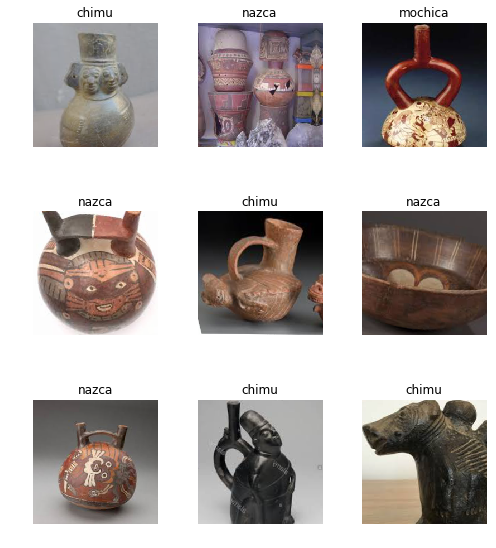

In [6]:
data.show_batch(rows=3, figsize=(7,8))

In [7]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['chimu', 'mochica', 'nazca'], 3, 752, 188)

## First pass at training a Model

Let's train a model. We will use the 'raw' data that we donwloaded. We don't expect very good results because we know that the dataset has some problems that we have already alluded to. We also noticed several items that were not picture. These will affect the results, but we need to do this so that we can clean up the data set later on.

### Train the Model

Create and train a first model to see how things are

In [9]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

In [10]:
learn.fit_one_cycle(8)

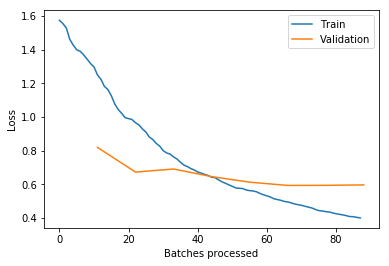

In [11]:
learn.recorder.plot_losses()

In [12]:
learn.save('stage-1')

The results are not very good. Let's see if we can work on this and improve the results

In [13]:
learn.load('stage-1');

In [14]:
learn.unfreeze()

In [15]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


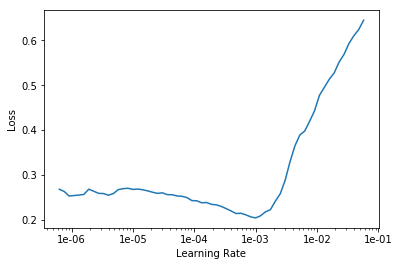

In [16]:
learn.recorder.plot()

In [17]:
learn.fit_one_cycle(4, max_lr=slice(1e-4,1e-5))
#learn.fit_one_cycle(4,0.1e-2)

In [18]:
learn.save('stage-2')

In [19]:
learn.load('stage-2');

In [20]:
interp = ClassificationInterpretation.from_learner(learn)

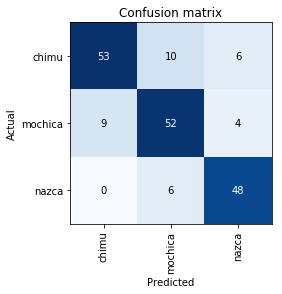

In [21]:
interp.plot_confusion_matrix()

In [22]:
interp.most_confused(min_val=2)

[('chimu', 'mochica', 10),
 ('mochica', 'chimu', 9),
 ('chimu', 'nazca', 6),
 ('nazca', 'mochica', 6),
 ('mochica', 'nazca', 4)]

The confusion matrix above does confirm my initial statement that the model was not doing very well. Let's try to clean up the model and remove images that should be there to see if we can improve things

## Cleaning up the data

`top_loss_paths` contains all of the file names in our dataset. When I say "our dataset", this particular one is our validation dataset. So what this is going to do is it's going to clean up mislabeled images or images that shouldn't be there and we're going to remove them from a validation set so that our metrics will be more correct. You then need to rerun these two steps replacing valid_ds with train_ds to clean up your training set to get the noise out of that as well. 

Please note that there is a lot of manual labor involved below. The clean up involves visually inspecting the images (the cells below that will generate the data for inspection) and making decisions. Unfortunately this cannot be captued in the notebook. You can ignore this clean up step, but understand that the accuracy of the model will suffer. For educational purposes, I supppse this would be OK, but learning to clean up data is a critical step in creating datasets for training CNN models, so I think you should at least understand what is going on.

In [26]:
from fastai.widgets import *

In order to clean the entire set of images, we need to create a new dataset without the split. 

In [27]:
db = (ImageList.from_folder(path)
                   .split_none()
                   .label_from_folder()
                   .transform(get_transforms(), size=224)
                   .databunch()
     )

In [28]:
learn_cln = cnn_learner(db, models.resnet34, metrics=error_rate)

learn_cln.load('stage-2');

In [29]:
ds, idxs = DatasetFormatter().from_toplosses(learn_cln)

In [30]:
ImageCleaner(ds, idxs, path)

'No images to show :)'

Now look for duplicates

In [31]:
ds, idxs = DatasetFormatter().from_similars(learn_cln)

Getting activations...


Computing similarities...


In [32]:
ImageCleaner(ds, idxs, path, duplicates=True)

'No images to show :). 73 pairs were skipped since at least one of the images was deleted by the user.'

In [75]:
#doc(ImageList.from_csv)

Now create a new databunch from the cleanued up data

In [120]:
np.random.seed(42)
db_clean = (ImageList.from_csv(path, 'cleaned.csv', folder='.')
                    #.split_none()
                    .split_by_rand_pct(0.1)
                    .label_from_df()
                    .transform(get_transforms(), size=224)
                    .databunch()
      )

## Train a New Learner

Now that we have a cleaned up data set: removed mislabled images or non photographs and/or duplicates, we should train a new learner using the *cleaned up* dataset.

In [121]:
learn_cln = cnn_learner(db_clean, models.resnet50, metrics=error_rate)

In [122]:
learn_cln.fit_one_cycle(8)

In [123]:
learn_cln.save('stage-3')

In [124]:
learn_cln.load('stage-3');

In [125]:
learn_cln.unfreeze()

In [126]:
learn_cln.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


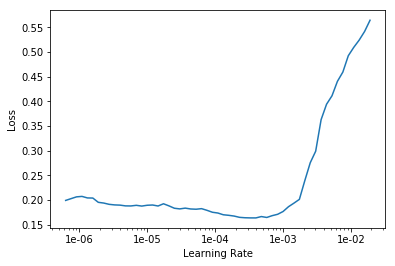

In [127]:
learn_cln.recorder.plot()

In [128]:
#learn.fit_one_cycle(8, max_lr=slice(1e-4,1e-3))
learn_cln.fit_one_cycle(16,4e-4)

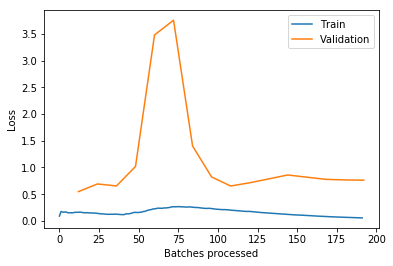

In [129]:
learn_cln.recorder.plot_losses()

In [130]:
interp = ClassificationInterpretation.from_learner(learn_cln)

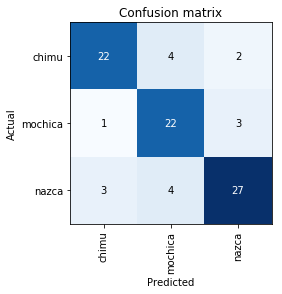

In [131]:
interp.plot_confusion_matrix()

In [132]:
interp.most_confused(min_val=2)

[('chimu', 'mochica', 4),
 ('nazca', 'mochica', 4),
 ('mochica', 'nazca', 3),
 ('nazca', 'chimu', 3),
 ('chimu', 'nazca', 2)]

In [143]:
pwd

'/mnt/work/dev/huaquero'

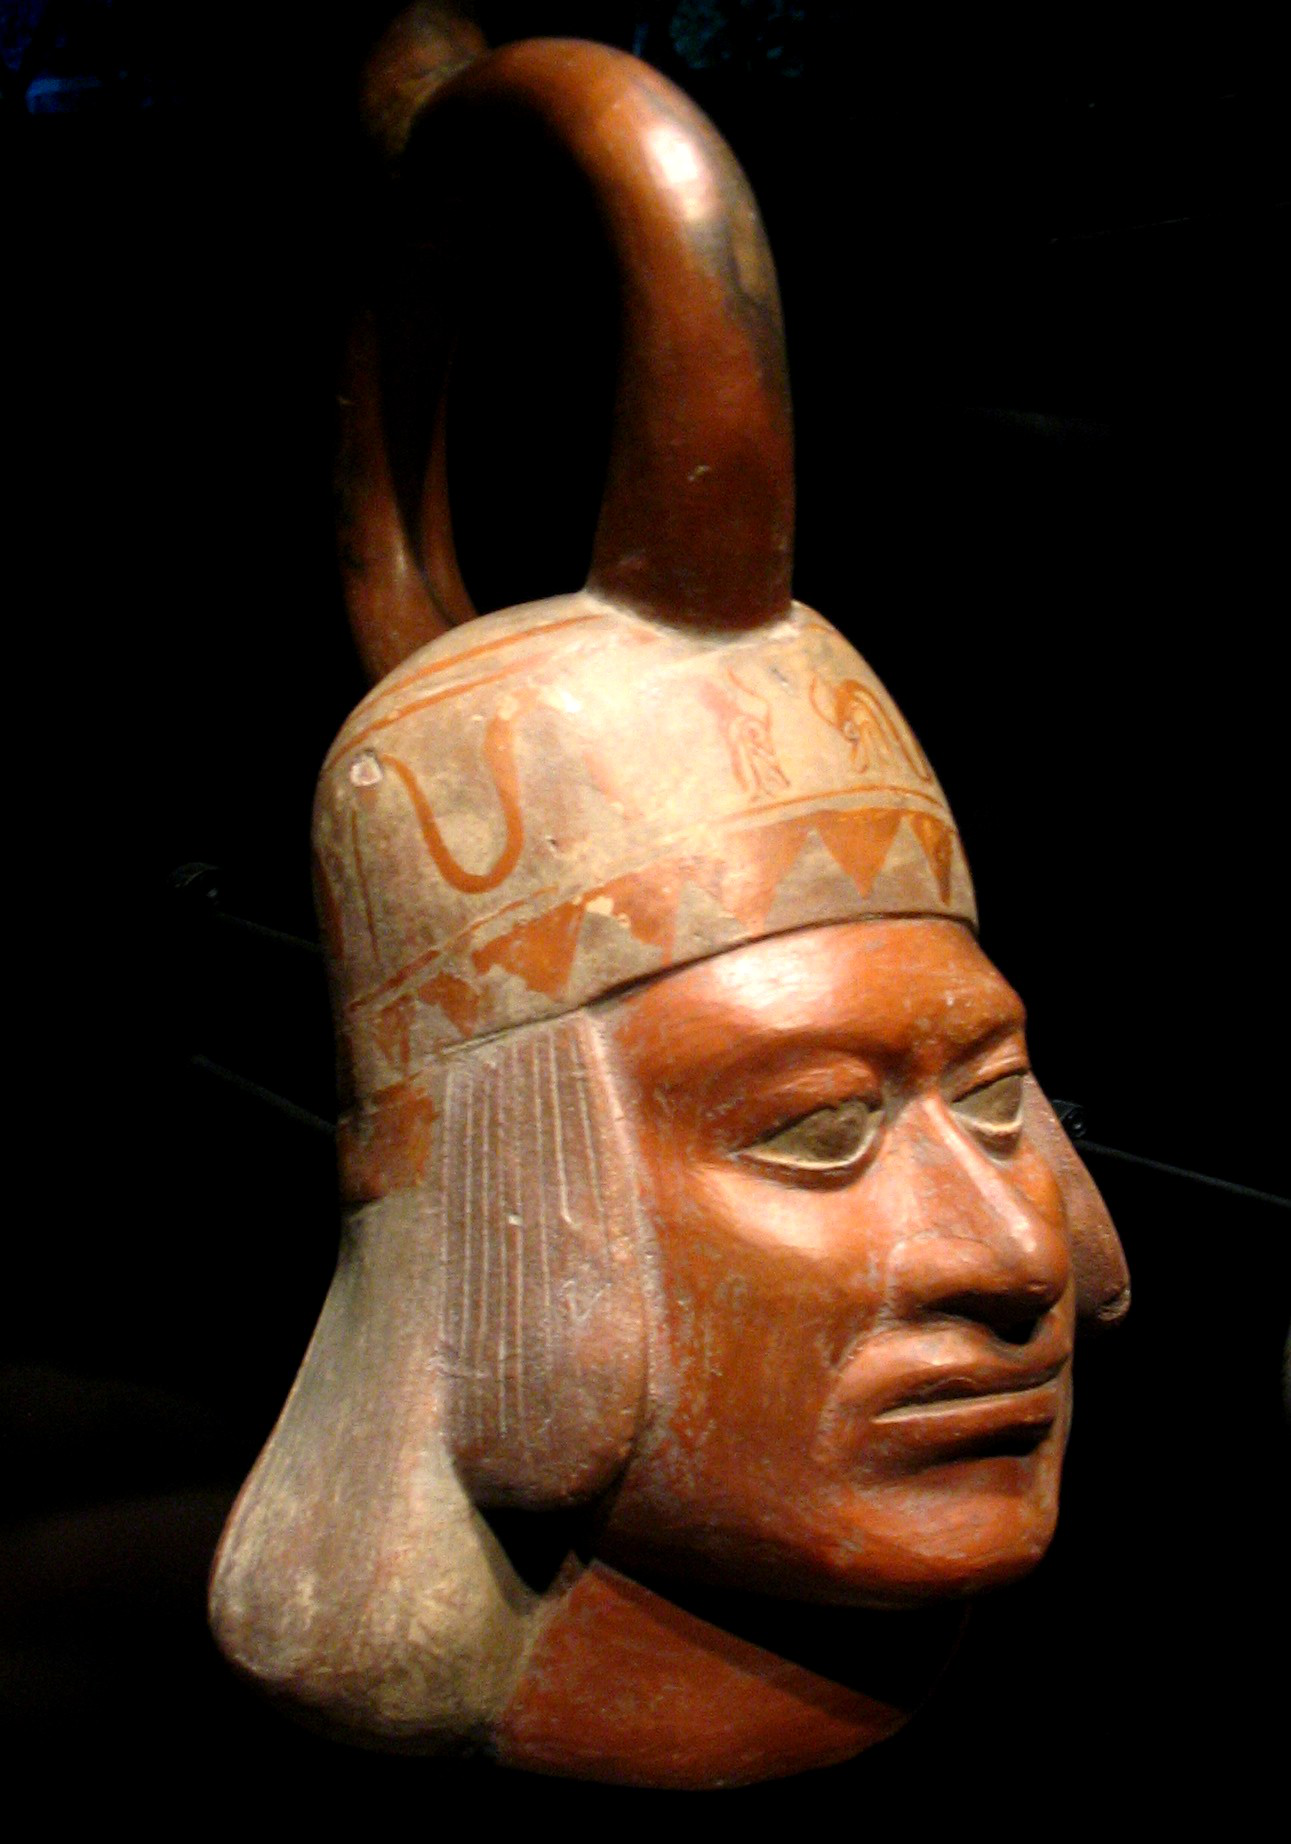

In [147]:
#img = open_image('/mnt/work/dev/huaquero/test/mochica.jpeg')
img = open_image('test/mochica.jpeg')
img

In [148]:
pred_class,pred_idx,outputs = learn.predict(img)
pred_class

Category mochica

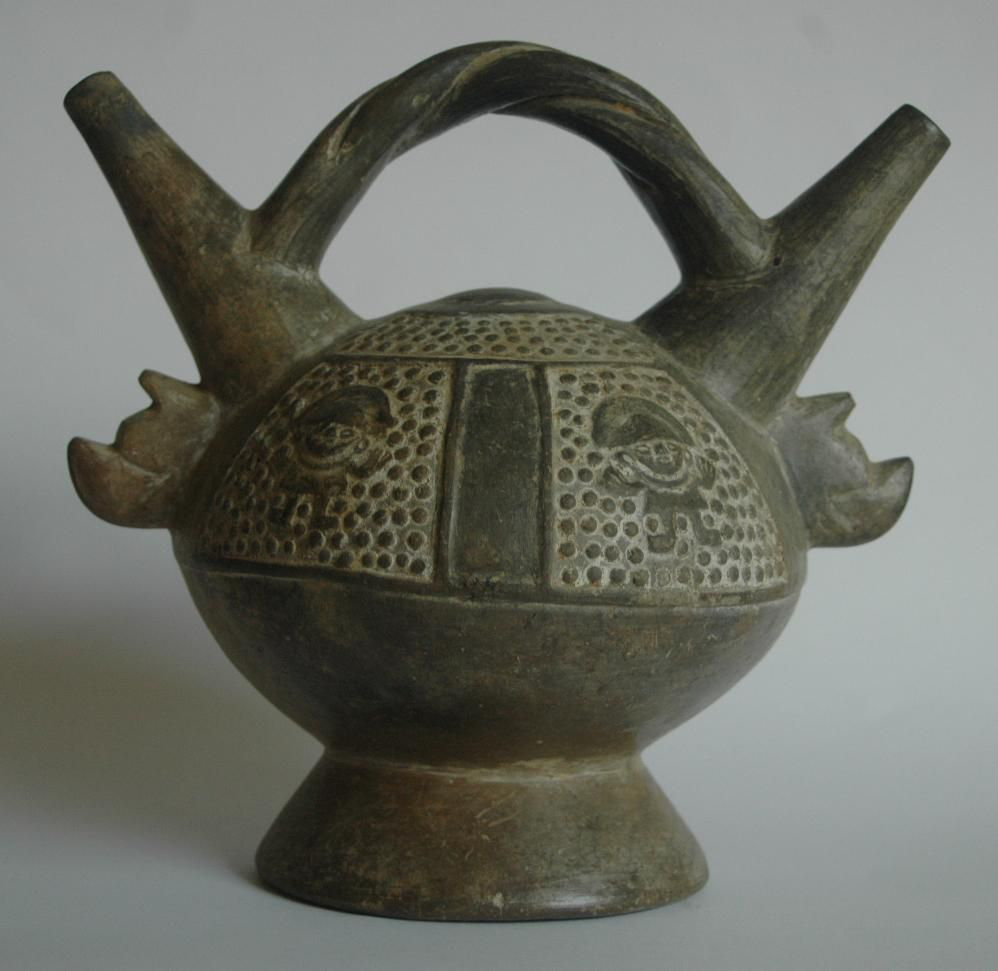

In [151]:
img = open_image('test/chimu.jpeg')
img

In [150]:
pred_class,pred_idx,outputs = learn.predict(img)
pred_class

Category chimu

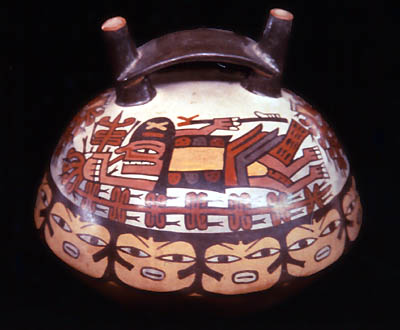

In [153]:
img = open_image('test/nazca.jpeg')
img

## Testing the model
You can test the model by setting `img` to point the image you want to analyze as follows:

`img = open_image('test/nazca.jpeg')`

The call the `learn.predict` method. It will return the Category.

In [154]:
pred_class,pred_idx,outputs = learn.predict(img)
pred_class

Category nazca